<a href="https://colab.research.google.com/github/rezamohamadlo/Clothes-Recognition/blob/main/Clothes_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import keras  # Import Keras for building neural networks
from __future__ import absolute_import  # Ensures compatibility with future versions
from __future__ import print_function  # Allows print function to work consistently across Python versions

import numpy as np  # Import NumPy for numerical operations
import random  # Import random for generating random numbers

# Import the MNIST dataset from Keras
from keras.datasets import mnist

# Import necessary components from Keras for building models
from keras.models import Model  # Import Model class for creating Keras models
from keras.layers import Input, Flatten, Dense, Dropout, Lambda  # Import various layer types
from keras.layers import Conv2D, Activation, AveragePooling2D, MaxPooling2D  # Import convolutional and pooling layers

# Import RMSprop optimizer for training the model
from keras.optimizers import RMSprop

# Import Keras backend functions for tensor operations
from tensorflow.keras import backend as K

# Import Matplotlib for plotting results
import matplotlib.pyplot as plt

# Import PIL (Python Imaging Library) for image processing tasks
from PIL import Image

# Import TensorFlow (Keras is built on top of TensorFlow)
import tensorflow as tf

In [2]:
# Function to compute the Euclidean distance between two vectors
def euclid_dis(vects):
    # Unpack the input vectors
    x, y = vects
    # Calculate the sum of squared differences between the two vectors
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    # Return the square root of the sum of squares, ensuring numerical stability with K.epsilon()
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

# Function to define the output shape of the Euclidean distance layer
def eucl_dist_output_shape(shapes):
    # Unpack the shapes of the input tensors
    shape1, shape2 = shapes
    # Return the shape of the output, which is (batch_size, 1)
    return (shape1[0], 1)

# Contrastive loss function for training a Siamese network
def contrastive_loss(y_true, y_pred):
    margin = 1  # Define a margin for the loss calculation
    # Calculate the squared predictions
    square_pred = K.square(y_pred)
    # Calculate the squared margin loss for predictions that exceed the margin
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    # Return the mean contrastive loss across all samples
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [3]:
# Function to create pairs of images and their corresponding labels for training
def create_pairs(x, digit_indices):
    pairs = []  # List to hold the image pairs
    labels = []  # List to hold the labels corresponding to the pairs

    # Determine the number of pairs to create based on the minimum number of samples per class
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1

    # Loop through each digit class
    for d in range(num_classes):
        # Create pairs of similar images (same class)
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]  # Get indices of two similar images
            pairs += [[x[z1], x[z2]]]  # Append the pair to the list of pairs

            # Create a pair of dissimilar images (different classes)
            inc = random.randrange(1, num_classes)  # Randomly select another class
            dn = (d + inc) % num_classes  # Ensure the class index wraps around
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]  # Get indices for one image from the current class and one from the new class
            pairs += [[x[z1], x[z2]]]  # Append the dissimilar pair

            labels += [1, 0]  # Append labels: 1 for similar pair, 0 for dissimilar pair

    return np.array(pairs), np.array(labels)  # Return the pairs and their corresponding labels as numpy arrays

In [4]:
# Function to create a base neural network model for feature extraction
def create_base_net(input_shape):
    # Define the input layer with the specified input shape
    input = Input(shape=input_shape)

    # First convolutional layer: 32 filters, 3x3 kernel, ReLU activation
    x = Conv2D(32, (3, 3), activation='relu')(input)

    # First average pooling layer: reduces spatial dimensions by taking the average over a 2x2 window
    x = AveragePooling2D(pool_size=(2, 2))(x)

    # Second convolutional layer: 64 filters, 3x3 kernel, Tanh activation
    x = Conv2D(64, (3, 3), activation='tanh')(x)

    # Second max pooling layer: reduces spatial dimensions by taking the maximum over a 2x2 window
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Dropout layer: randomly sets a fraction (25%) of input units to 0 during training to prevent overfitting
    x = Dropout(0.25)(x)

    # Flatten layer: flattens the output from the convolutional layers into a 1D vector
    x = Flatten()(x)

    # Fully connected layer: 128 units, Tanh activation
    x = Dense(128, activation='tanh')(x)

    # Dropout layer: randomly sets a fraction (50%) of input units to 0 during training to prevent overfitting
    x = Dropout(0.5)(x)

    # Fully connected layer: 64 units, Tanh activation
    x = Dense(64, activation='tanh')(x)

    # Dropout layer: randomly sets a fraction (50%) of input units to 0 during training to prevent overfitting
    x = Dropout(0.5)(x)

    # Output layer: 10 units (for classification), Tanh activation
    x = Dense(10, activation='tanh')(x)

    # Create the model using the defined input and output layers
    model = Model(input, x)

    # Print a summary of the model architecture
    model.summary()

    return model  # Return the constructed model

In [5]:
# Function to compute classification accuracy based on a fixed threshold on distances
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.'''
    # Flatten the predictions and check if they are less than 0.5 (threshold)
    pred = y_pred.ravel() < 0.5
    # Calculate the mean accuracy by comparing predictions with true labels
    return np.mean(pred == y_true)

# Function to compute classification accuracy using Keras backend
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.'''
    # Compare true labels with predicted labels (after applying threshold) and calculate mean accuracy
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

# Load the MNIST dataset (handwritten digits)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape the input data to include a channel dimension (for grayscale images)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Print the shape of the training data to verify the reshaping
print(x_train.shape)

# Convert the data type to float32 for model compatibility
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize pixel values to be between 0 and 1 by dividing by 255
x_train /= 255
x_test /= 255

# Define the input shape for the model based on reshaped training data
input_shape = x_train.shape[1:]
input_shape = (28, 28, 1)  # Explicitly set input shape for clarity

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28, 1)


In [6]:
# Define the number of classes in the dataset (10 for MNIST digits 0-9)
num_classes = 10

# Create training and test positive and negative pairs for the Siamese network
# `digit_indices` holds the indices of samples for each digit class in the training set
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
# Generate training pairs and their corresponding labels using the `create_pairs` function
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

# Repeat the process for the test set
# `digit_indices` holds the indices of samples for each digit class in the test set
digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
# Generate test pairs and their corresponding labels using the `create_pairs` function
te_pairs, te_y = create_pairs(x_test, digit_indices)

# Network definition: Create the base network model for feature extraction
base_network = create_base_net(input_shape)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 232,650 (908.79 KB)

 Trainable params: 232,650 (908.79 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Define two input layers for the Siamese network, one for each image in the pair
input_a = Input(shape=input_shape)  # Input for the first image
input_b = Input(shape=input_shape)  # Input for the second image

# Process both inputs through the base network to extract features
processed_a = base_network(input_a)  # Features extracted from the first input
processed_b = base_network(input_b)  # Features extracted from the second input

# Compute the distance between the two processed feature vectors using a custom distance function
distance = Lambda(euclid_dis,  # Use the Euclidean distance function defined earlier
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])  # Specify output shape

# Create a Keras model that takes two inputs and outputs their distance
model = Model([input_a, input_b], distance)

In [8]:
# Set the number of epochs for training the model
epochs = 20

# Initialize the RMSprop optimizer
rms = RMSprop()

# Compile the model with the contrastive loss function, RMSprop optimizer, and accuracy metric
model.compile(loss=contrastive_loss,  # Loss function to minimize
              optimizer=rms,  # Optimizer for updating model weights
              metrics=[accuracy])  # Metric to evaluate during training

# Train the model using the training pairs and labels
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,  # Input pairs and their corresponding labels
          batch_size=128,  # Number of samples per gradient update
          epochs=epochs,  # Number of times to iterate over the training data
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))  # Validation data for evaluating performance during training

Epoch 1/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.5023 - loss: 0.1793 - val_accuracy: 0.5000 - val_loss: 0.0742
Epoch 2/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.5030 - loss: 0.1022 - val_accuracy: 0.5000 - val_loss: 0.0565
Epoch 3/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5029 - loss: 0.0907 - val_accuracy: 0.5000 - val_loss: 0.0537
Epoch 4/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5037 - loss: 0.0829 - val_accuracy: 0.5000 - val_loss: 0.0496
Epoch 5/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5037 - loss: 0.0783 - val_accuracy: 0.5000 - val_loss: 0.0492
Epoch 6/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5033 - loss: 0.0741 - val_accuracy: 0.5000 - val_loss: 0.0452
Epoch 7/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5035 - loss: 0.0705 - val_accuracy: 0.5000 - val_loss: 0.0418
Epoch 8/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5039 - loss: 0.0665 - val_accuracy:

In [9]:
# Compute final accuracy on the training set
# Use the trained model to predict distances for the training pairs
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
# Calculate the accuracy of the predictions using the compute_accuracy function
tr_acc = compute_accuracy(tr_y, y_pred)

# Compute final accuracy on the test set
# Use the trained model to predict distances for the test pairs
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
# Calculate the accuracy of the predictions for the test set
te_acc = compute_accuracy(te_y, y_pred)

# Print the accuracy results for both training and test sets
print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))  # Format and display training accuracy
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))      # Format and display test accuracy

3388/3388 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
557/557 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
* Accuracy on training set: 97.59%
* Accuracy on test set: 96.45%


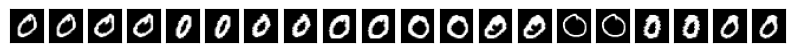

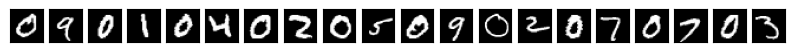

[0.02802661]
[0.92600703]
[0.03401873]
[0.59025306]
[0.04951794]
[1.160032]
[0.127751]
[0.42095587]
[0.05780412]
[1.423219]
[0.00802645]
[0.59032536]
[0.06966292]
[1.5064734]
[0.03344971]
[1.3870462]
[0.08790328]
[1.2621258]
[0.04994301]
[1.3413448]


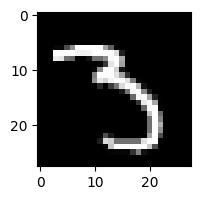

In [10]:
# Set the number of items to display
number_of_items = 20

# Convert the first image from the training pairs to a PIL image for display
im = tf.keras.preprocessing.image.array_to_img(
    tr_pairs[1, 0],  # Select the first image from the first pair
    data_format=None,
    scale=True,  # Scale pixel values to [0, 1]
    dtype=None
)

# Create a figure to display the first set of images (first elements of pairs)
plt.figure(figsize=(10, 5))
for item in range(number_of_items):
    # Create a subplot for each image
    display = plt.subplot(1, number_of_items, item + 1)
    # Convert the current image in the training pairs to a PIL image
    im = tf.keras.preprocessing.image.array_to_img(tr_pairs[item, 0], data_format=None, scale=True, dtype=None)
    plt.imshow(im, cmap="gray")  # Display the image in grayscale
    display.get_xaxis().set_visible(False)  # Hide x-axis ticks
    display.get_yaxis().set_visible(False)  # Hide y-axis ticks
plt.show()  # Show the figure with images

# Create a figure to display the second set of images (second elements of pairs)
plt.figure(figsize=(10, 5))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items, item + 1)
    im = tf.keras.preprocessing.image.array_to_img(tr_pairs[item, 1], data_format=None, scale=True, dtype=None)
    plt.imshow(im, cmap="gray")  # Display the image in grayscale
    display.get_xaxis().set_visible(False)  # Hide x-axis ticks
    display.get_yaxis().set_visible(False)  # Hide y-axis ticks
plt.show()  # Show the figure with images

# Print predicted distances for the first few items
for i in range(number_of_items):
    print(y_pred[i])

# Display one of the images again (the last processed image)
plt.figure(figsize=(20, 2))
plt.imshow(im, cmap="gray")  # Show the last image in grayscale
plt.show()  # Show the figure with the image